In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV

<font  style="font-size: 4rem; color: #1abc9c"> SVM </font>

# <font color="#1E90FF">Exercise 1. Linear SVM - Influence of hyper-parameter C</font>

## <font color="#9400D3">1. Load, analyze and visualize data</font>

Warning: in this particular exercise, we will not split the dataset in train/val/test.

In [97]:
dataset = pd.read_csv('./LineaireNoisy.txt', delimiter='\t')
dataset

,x1,x2,y
0,9.50,10.00,0
1,14.25,16.55,1
2,10.00,5.00,1
3,2.30,5.25,0
4,3.40,3.88,0
...,...,...,...
147,15.01,15.67,1
148,16.05,14.70,1
149,15.65,18.23,1
150,18.85,17.43,1


<font color="red">**Question 1:**</font> 
- How many examples $\boldsymbol{x}^{(1)}, \boldsymbol{x}^{(2)},...\boldsymbol{x}^{(n)}$ in the dataset?
- How many features $x_1, x_2,...x_d$ ? What are their types? Their distribution?
- What are the classes?
- What is the class distribution over the dataset?

In [98]:
print("number of examples: ", dataset.shape[0])
print("number of features: ", dataset.shape[1])
print("Classes: ", dataset['y'].unique())
print("Distribution of classes :") 
print(dataset['y'].value_counts())

number of examples:  152
number of features:  3
Classes:  [0 1]
Distribution of classes :
0    76
1    76
Name: y, dtype: int64


### Plotting the dataset

<AxesSubplot: xlabel='x1', ylabel='x2'>

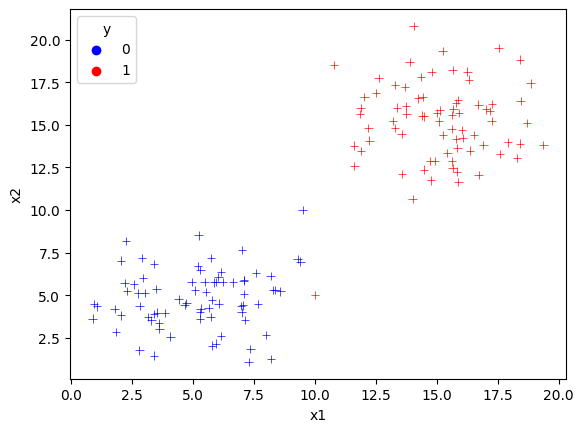

In [99]:
sns.scatterplot(data=dataset, x='x1', y='x2', hue='y', marker='+', palette=['blue','red'])

<font color="red">**Question 2:**</font>  Is this dataset linearly separable ? Find some examples that are close to the boundary

Sur le graphe ci-dessous, les points bleus et les points rouges sont clairement séparables avec une droite. 
Il y a juste un point rouge qui potentiellement pourrait être mal classé.
![q2](./exo1.png)

## <font color="#9400D3">2. Fitting a linear SVM to this dataset</font>

One implementation of SVM is done by class <code>SVC</code>, which stands for Support Vector Classification.
Documentation is available: 
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [100]:
# SVC with linear kernel, and parameter C set to 1000
model_svm = svm.SVC(C = 1000, kernel = 'linear')

# Fit the model using the features (x1 and x2) and the target (y)
model_svm.fit(dataset.iloc[:,0:2], dataset.y)

SVC(C=1000, kernel='linear')

### Visualizing the SVM model

Run the following cells to see a plot of your dataset together with the decision boundary and the margins.

In [101]:
def svm_draw(model_svm, xmin, xmax, dataset):
    
    color_map = matplotlib.colors.ListedColormap(pd.Series(['blue', 'red']))


    plt.figure(figsize=(10, 8))
    # Plotting our two-features-space
    plt.scatter(dataset.iloc[:,0], dataset.iloc[:,1], c = dataset.y, cmap = color_map, marker='+')
    # Constructing a hyperplane using a formula.
    w = model_svm.coef_[0]           # w consists of 2 elements
    b = model_svm.intercept_[0]      # b consists of 1 element
    x_points = np.linspace(xmin, xmax)    # generating x-points from -1 to 1
    y_points = -(w[0] / w[1]) * x_points - b / w[1]  # getting corresponding y-points

    plt.plot(x_points, y_points, c='g');

    plt.scatter(model_svm.support_vectors_[:, 0],
                model_svm.support_vectors_[:, 1], 
                s=50, 
                facecolors='none', 
                edgecolors='k', 
                alpha=1);

    # Step 2 (unit-vector):
    w_hat = model_svm.coef_[0] / (np.sqrt(np.sum(model_svm.coef_[0] ** 2)))
    # Step 3 (margin):
    margin = 1 / np.sqrt(np.sum(model_svm.coef_[0] ** 2))
    # Step 4 (calculate points of the margin lines):
    decision_boundary_points = np.array(list(zip(x_points, y_points)))
    points_of_line_above = decision_boundary_points + w_hat * margin
    points_of_line_below = decision_boundary_points - w_hat * margin
    # Plot margin lines
    # Blue margin line above
    plt.plot(points_of_line_above[:, 0], 
             points_of_line_above[:, 1], 
             'g--', 
             linewidth=2)
    # Green margin line below
    plt.plot(points_of_line_below[:, 0], 
             points_of_line_below[:, 1], 
             'g--',
             linewidth=2)

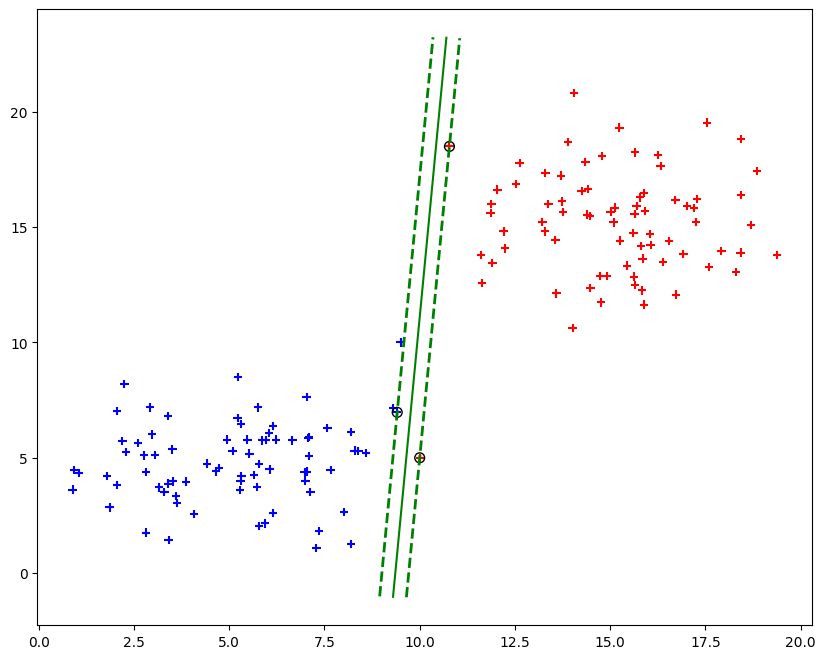

In [102]:
svm_draw(model_svm, 9.3, 10.7, dataset)

<font color="red">**Question 3:**</font>  
- What do you think of this boundary and these margins?
- How many points are inside the margins?
- How many points are misclassified by this model?

Dans ce cas particulier la ligne séparatrice permet de corectement séparer les données de notre dataset :
- La droite sépare bien les deux classes (il y a 0 points mal classé),
- Les marges sont équidistantes aux points les plus rapprochés de classes différentes,
- Mais les points sont trops rapprochés de la marge pour considérer le modèle comme optimal.

En effet, dans le cas général, cette droite peut ne pas correspondre à la meilleure séparation possible car des points peuvent apparaitre au alentours de la marge qui n'est pas assez large pour nous donner assez de "jeu". 

Ce modèle fait de l'**overfitting** et **ne peut pas généraliser de nouvelle données**. Nous allons donc voir comment trouver la meilleure droite de séparation.


- overfitting: the model is too complex and does not generalize well to new data
- inside margin : 3 points
- misclassified : 0 points


### SVM model analysis

We can also retrieve more precise information about the model that will allow us to understand its decision process.

Course reminder: when fitting a SVM model, a Lagrange coefficient is associated to each sample. In addition, one more parameter is also estimated: the constant of the model.

We can find these informations by the following commands:

In [103]:
model_svm.support_vectors_
# the support vectors found by the SVC

array([[ 9.41,  6.97],
       [10.  ,  5.  ],
       [10.78, 18.49]])

In [104]:
model_svm.support_
# the index of the support vectors in the dataset

array([ 62,   2, 102], dtype=int32)

In [105]:
model_svm.dual_coef_
# the lagrange coefficients associated to the support vectors (alpha_i) multiplied by their targets (y_i)

array([[-4.04838982,  3.46935572,  0.5790341 ]])

In [106]:
model_svm.intercept_
# the constant of the model (w0)

array([-26.58177221])

<font color="red">**Question 4:**</font>  
- How many support vectors?
- What are the classes $y_i$ associated to each support vector?
- What are lagrange coefficients $\alpha_i$ associated to each support vector?

Be carefull: 'dual_coef_' returns the lagrange coefficients associated to the support vectors **multiplied by their targets** 

In [107]:
print("Support Vectors : ")
indexes = model_svm.support_
print(dataset.iloc[indexes, 0:2], end="\n\n")

print("Number of support vectors: ", model_svm.support_vectors_.shape[0])
classes_support_vectors = dataset.iloc[model_svm.support_, 2]
print(end="\n")

print("Classes y_i associated to the support vectors: ")
print(classes_support_vectors, end="\n\n")

print("Lagrange coefficients alpha_i associated to the support vectors: ")
lagrange_coefficients = model_svm.dual_coef_[0]
for i in range(model_svm.support_vectors_.shape[0]):
    print("alpha_{} = {}".format(i, lagrange_coefficients[i]), end="\n")

print("w0 = ", model_svm.intercept_[0])

Support Vectors : 
        x1     x2
62    9.41   6.97
2    10.00   5.00
102  10.78  18.49

Number of support vectors:  3

Classes y_i associated to the support vectors: 
62     0
2      1
102    1
Name: y, dtype: int64

Lagrange coefficients alpha_i associated to the support vectors: 
alpha_0 = -4.048389823022215
alpha_1 = 3.469355722298181
alpha_2 = 0.5790341007240324
w0 =  -26.581772205040433


Il y a 3 supports vecteurs : 

| x1 | x2 | Class (y) | Lagrande coef |
| --- | --- | --- | --- |
| 9.41  | 6.97 | 0 |  -4.04838982  |
| 10.00  | 5.00 | 1 |  3.46935572  |
| 10.78 | 18.49 | 1 |  0.5790341  |



<font color="red">**Question 5:**</font> 
Deduce the equation $h_w(x)$ of this model. 

Formule de $h_w(x)$ :

$$
h_w(x)= \sum_{i=1}^{m} \alpha_i^* y^{(i)} (x \bullet x^{(i)}) + w_0^*
$$

$$
h(x)=-4.04838982*(-1)*(9.41*6.97)+3.46935572*1*(10.00*5.00)+0.5790341*1*(10.78*18.49)+-26.581772205040433
$$

### Classification with SVM model

<font color="blue">**todo:**</font> Apply the previous formula to compute the decisions $\hat{y}$ for the 2 first examples of the dataset. 

Hints: dot product between 2 vectors $x_1$ and $x_2$ is done by <code>np.dot(x_1, x_2)</code>.

<font color="red">**Question 6:**</font> 
- What represents the value $h_w(x)$?
- Are these examples correctly classified?

In [115]:
# first and second point in the dataset
point1 = dataset.iloc[0, 0:2]
point2 = dataset.iloc[1, 0:2]
y1 = dataset.iloc[0, 2]
y2 = dataset.iloc[1, 2]
print("point1: \n", point1, "y1: ", y1)
print("point2: \n", point2, "y2: ", y2)

def h(x):
    # return model_svm.coef_[0][0] * x1 + model_svm.coef_[0][1] * x2 + model_svm.intercept_[0]
    return -4.04838982*(-1)*(np.dot(x[0], x[1]))+3.46935572*(np.dot(x[0], x[1])) + 0.5790341*(np.dot(x[0], x[1])) - 26.581772205040433


print(h(point1))
print(h(point2))

point1: 
 x1     9.5
x2    10.0
Name: 0, dtype: float64 y1:  0
point2: 
 x1    14.25
x2    16.55
Name: 1, dtype: float64 y2:  1
742.6122935949594
1882.9424961434595


You can obtain the $h_w(x)$ values for the examples in the dataset using the function 
<code>decision_function</code>.

Check your results.

In [42]:
print(model_svm.decision_function(dataset.iloc[:2,0:2]))
print('\n',dataset.iloc[:2,:])

[-1.24148389 11.17421548]

       x1     x2  y
0   9.50  10.00  0
1  14.25  16.55  1


<font color="red">**Question 6:**</font> what are the decision values for the support vectors? Which values are expected for support vectors? 

In [43]:
# TODO: print the decision values for the support vectors

## <font color="#9400D3">3. Change the hyperparameter C</font>

Even if the dataset is linearly separable, the previous boundary is not very adapted. Because C is very high the model favours no training error. 

<font color="blue">**Todo:**</font> 
- Fit a model with a smaller value of C: C = 1
- Plot the new boundary and margins

<font color="red">**Question 7:**</font> 
 - How many support vectors are selected ?
 - How many points are inside the margins ? on the margins ?
 - How many points from the dataset are misclassified ?
 - What are the lagrange values of $\alpha$ for the support vectors ?
 - What are the values of $h_w(x)$ for the support vectors ?

In [44]:
# TODO - Fit a SVM model with C=1 


In [45]:
# TODO - Visualize boundary and margins

<font color="red">**Question 8:**</font>  Same questions for C = 0.01.

hint: you'll have to modify xmin and xmax in the <code>svm_draw</code> function to 3 and 17

In [46]:
# TODO - Fit a SVM with C=0.01

<font color="red">**Question 9:**</font>  what can you conclude about the influence of C ?

# <font color="#1E90FF">Exercise 2: Choosing C using train/val/test split</font>

In this exercise, you will choose the best value of C (for a given dataset) by the same procedure as for the other algorithms: train/validation/test split

In [47]:
# Load the dataset
dataset = pd.read_csv("./data/spam7.csv", decimal=",", index_col=0, delimiter = ";")
dataset
# A description about this dataset is given here:
# https://rdrr.io/cran/DAAG/man/spam7.html

FileNotFoundError: [Errno 2] No such file or directory: './data/spam7.csv'

<font color="red">**Question 1:**</font>  How many examples ? How many features ? What is the distribution of the target ?

In [ ]:
# TODO - dataset analysis

SVM can be very long to fit when the dataset is big (number of examples, number of features).
It is better to scale the features before fitting a model. A classical scaling is the standard scaler, which removes the mean and divide by the standard deviation. Hence, after this operation, each feature has a mean of zero and a standard deviation of 1. 

In [ ]:
from sklearn.preprocessing import StandardScaler
# First, get the features
X = dataset.iloc[:,0:6]
# then create a scaler on X
scaler = StandardScaler().fit(X)
# Apply it to X
X = scaler.transform(X)
# create a dataframe with X
X = pd.DataFrame(X, columns=dataset.columns[0:6])
X.describe()

# You should see that the features have been transformed
# print(X.dollar.mean())
# the mean of feature 'dollar' is now 0 (very close to 0)
# it is the same for the other features

In [ ]:
# Now we will add the target variable inside X
X['yesno'] = dataset.yesno
X
# now our dataset is called X

<font color="blue">todo:</font>  Split this dataset into training/validation/test 

In [ ]:
# TODO - train/validation/test splitting

<font color="red">**Question 2:**</font> 
 - Fit a first linear SVM model with C = 1
 - How many support vectors are selected ?
 - What is the performance of this model on the training set ? on the test set ?
 - What is the confusion matrix of the predictions of the test set ? What kind of errors is more often made? (check <code>confusion_matrix</code> function for that)

In [ ]:
# TODO - Fit a linear SVM model with C = 1

<font color="blue">**Todo:**</font>  
- Try different values of C (between 0.01 and 1000 for instance, by order of magnitude) and compute the training and validation scores for each value of C (use a'for' loop). 
- Select the best value of C and estimate the generalization error of the selected SVM.

In [ ]:
# TODO - this can take some computing time

In [ ]:
# TODO - estimate the generalization error of the selected SVM

<font color="red">**Question 3:**</font> 
- give the best C value
- compare the generalization error using this tuned value and the default value (C=1)

# <font color="#1E90FF">Exercise 3: Non-linear SVM</font>

We move here on SVM using kernel functions.

## <font color="#9400D3">1. Data analysis</font>

In [ ]:
# Load a dataset
dataset = pd.read_csv("./data/SepNonLineaire.csv")
dataset

<font color="red">**Question 1:**</font> How many examples? features? distribution of the target values ?

In [ ]:
print(dataset.y.value_counts())
dataset.describe()

In [ ]:
sns.scatterplot(data=dataset, x='x1', y='x2', hue='y', palette=sns.color_palette("deep")[0:2][::-1])
legend = plt.legend(frameon=True)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('b')

<font color="red">**Question 2:**</font> Is this dataset linearly separable ?

In [ ]:
# TODO - Split this dataset into training/validation/test

## <font color="#9400D3">2. Linear SVM</font>

<font color="blue">**Todo:**</font> try a linear SVM, compute the real error, and draw the boundaries, just to see.

In [ ]:
# TODO - linear SVM


In [ ]:
# TODO - draw the boundaries

## <font color="#9400D3">3. Radial SVM</font>

We will apply a radial SVM (with rbf kernel).
For this, you just need to specify <code>kernel = 'rbf'</code> rather than <code>kernel = 'linear'</code>.
And you'll also need to set a value for gamma (otherwise there is a default value)

<font color="blue">**Todo:**</font> 
 - Fit a rbf SVM with C = 1 and gamma = 10
 - Compute train and validation scores
 - Plot the decision boundaries and the margins using the function <code>draw_boundary</code> above
 
<font color="red">**Question 3:**</font> 
What phenomenon can you observe here ?

In [ ]:
# TODO - Fit a radial SVM

In [ ]:
def draw_boundary(model, data, x_min, x_max, y_min, y_max):
    h = 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    zz = np.c_[xx.ravel(), yy.ravel()]
    zz = pd.DataFrame(zz)
    zz2 = zz
    pred_zz= pd.Series(model.predict(zz2))
    color_map = matplotlib.colors.ListedColormap(pd.Series(['blue', 'red']))
    fig = plt.figure(figsize=  (8,8))
    fig = plt.scatter(zz.iloc[:,0], zz.iloc[:,1], c = pred_zz, cmap = color_map, marker='+')
    fig = plt.scatter(data.iloc[:,0], data.iloc[:,1], s = 50, c = data.iloc[:,2], cmap = color_map)
    

In [ ]:
draw_boundary(model_svm, train_set, -3,4,-5,9)

<font color="blue">**Todo:**</font>
- Try now to modify C and gamma to have a better decision boundary
- Choose the best values of C and gamma 
- Estimate the generalization error of this SVM
- draw the boundaries

In [ ]:
# TODO - search for best C and gamma values using validation set

In [ ]:
# TODO - generalization error estimation

In [ ]:
# TODO - draw the boundaries

<font color="blue">**Todo:**</font> You can also try polynomial kernels by specifying <code>kernel = 'poly'</code>. You'll have to tune the parameter <code>'degree'</code> with this kernel.

Note that in SVC, polynomial kernel is defined as: $$ K(x,x')=(\gamma (x.x') + r)^d$$ where $d$ is specified by parameter <code>degree</code>, r by <code>coef0</code> (default=0.0).

In [ ]:
# TODO - Fit a polynomial kernel. Find the best C and degree using validation set

<font color="red">**Question 4:**</font> 
- Which are finally the best hyper-parameters?
- Evaluate the final model on the test set.

## <font color="#9400D3">4. Expert mode</font>

When tuning the hyper-parameters with a validation set, rather than using several 'for', scikit learn offers a <code>GridSearchCV(estimator, param_grid)</code> function : https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

The parameters of the estimator (classifier) are optimized by **cross-validated** grid-search over a parameter grid. Candidates are exhaustively generated from a grid of parameter values specified with the <code>param_grid</code> parameter.

In [ ]:
param_grid = [
              {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
              {'C': [1, 10, 100, 1000], 'degree': [2, 3, 4], 'kernel': ['poly']},
              {'C': [1, 10, 100, 1000], 'gamma': [0.01, 0.1, 1.0], 'kernel': ['rbf']},
              ]
print("\n # Tuning hyper-parameters")
clf = GridSearchCV(svm.SVC(), param_grid, cv=5)
clf.fit(train_set.iloc[:,:2], train_set.y)


print("Best parameters set found on training set:")
print(clf.best_params_)

y_pred = clf.predict(test_set.iloc[:,:2])
print("\n SVM on test set (parameter tuning) : \t", accuracy_score(test_set.y, y_pred), "\n")

<font color="red">**Question 5:**</font> 
- Explain how many learning are done in the above procedure.
- How the (hyper)-parameter are selected?
- Does that match your previous study?